# Import libraries

In [203]:
from transformers import AutoTokenizer, DataCollatorForLanguageModeling, AutoModelForCausalLM, Trainer, TrainingArguments, get_cosine_schedule_with_warmup
from datasets import load_dataset
import pathlib
import torch
import pandas
from collections import Counter
import re

# Load the data

We'll use the Million Song Dataset from Kaggle as our training data. We can use the Datasets class from Huggingface to quickly load the data, then we'll use visualization tools to see the artists in a subset of the data.

Using custom data configuration default-a497b4a7fe246336
Found cached dataset csv (/Users/renaef/.cache/huggingface/datasets/csv/default-a497b4a7fe246336/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317)


  0%|          | 0/1 [00:00<?, ?it/s]

<AxesSubplot:>

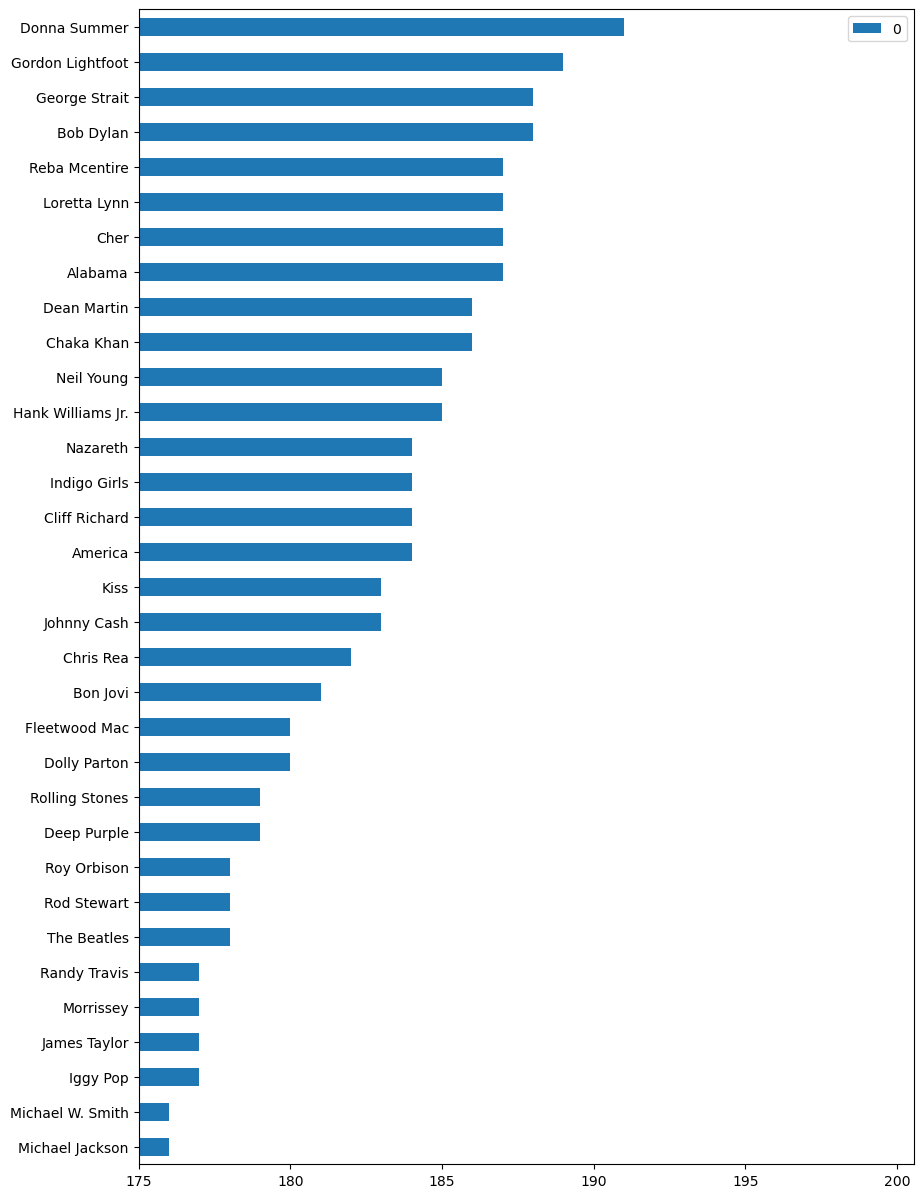

In [207]:
# Load the data and discard the dictionary wrapper.
dataset = load_dataset("csv", data_files="./data/spotify_millsongdata.csv")['train']

# Count how many times each artist appears in the data.
artist_counts = Counter(dataset['artist'])

# Choose artists with a number of songs in a certain range.
filtered_artists = dict(filter(lambda elem: elem[1] < 200 and elem[1] > 175, artist_counts.items()))

# Create a list of artists sorted by the number of songs they have in the data.
sorted_artists = dict(sorted(filtered_artists.items(), key=lambda item: item[1]))

# Plot the sorted list of artists.
df = pandas.DataFrame.from_dict(sorted_artists, orient='index')
df.plot(kind='barh',figsize=(10, 15),xlim= 175)

We'll select songs from one artist in our data, remove any irrelevant information, and divide the subset of data into training and test sets.

In [208]:
# Choose one artist with enough examples we can train on.
filtered_dataset = dataset.filter(lambda example: 'fleetwood mac' in example["artist"].lower())

# Remove unneeded columns and retain only the text column that holds the song lyrics.
filtered_dataset = filtered_dataset.remove_columns(["artist","song","link"])

# Split the data into test and training datasets (0.20 of the shuffled dataset will be reserved to test the model).
dataset_dict = filtered_dataset.train_test_split(test_size=0.20, shuffle=True, seed=123)

print(dataset_dict)

  0%|          | 0/58 [00:00<?, ?ba/s]

DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 144
    })
    test: Dataset({
        features: ['text'],
        num_rows: 36
    })
})


# Tokenize the data

We need to convert our text into numbers before we can put it into GPT-2. To do this, we can use a tokenizer that is specifically designed for GPT-2.

In [ ]:
# Create the GPT-2 text tokenizer. This will convert text into a numerical representation for the training process.
tokenizer = AutoTokenizer.from_pretrained('gpt2')

# Define a function that we'll use in the map function to tokenize data in the 'text' column.
def tokenize_function(examples):
    return tokenizer(examples["text"])

# Apply tokenizer on each song text in the dataset & remove the raw text column.
# It creates a dictionary with keys input_id and attention_mask, and each key references an array of arrays.
tokenized_datasets = dataset_dict.map(tokenize_function, batched=True, remove_columns=["text"])

# Create batched datasets

To to make the data compatible with GPT-2's input layer, we need to divide the data into sections that have fewer than 1024 tokens. We could truncate the data and use a DataCollator to pad it so that all input sequences have the same length. But, to preserve as much information as possible from the original data we will manually concatenate the data and then divide it into chunks based on the block size.

In [211]:
# Get the maximum length, in number of tokens, for the inputs to the GPT-2 model.
block_size = tokenizer.model_max_length

# Define a function that we'll use in a map function to format the data for the GPT-2 model.
def group_texts(examples):

    # Concatenate all tokenized texts and masks.
    # For each key in the dictionary, use sum(examples[key], []) to concatenate all lists.
    concatenated_examples = {key: sum(examples[key], []) for key in examples.keys()}

    # Get the total length of the concatenated texts.
    total_length = len(concatenated_examples["input_ids"])

    # Calculate the max length by rounding down the total length to the nearest block size. 
    max_length = (total_length // block_size) * block_size

    # Create a dictionary of keys with values split into chunks of max length.
    result_dict = {
        # From i to range of max_length, by block_size, create a list of values from i to i + block_size.
        keys: [values[i : i + block_size] for i in range(0, max_length, block_size)] 

        # Perform this for every key in the dictionary.
        for keys, values in concatenated_examples.items()
    }

    # Create labels from copies of the input_ids. This is necessary for language modeling. Since these are shifted inside the model, we can set input_ids = labels.
    result_dict["labels"] = result_dict["input_ids"].copy()

    return result_dict

# Use the map function and the group_texts function to format the data.
lm_datasets = tokenized_datasets.map(group_texts, batched=True)

print(lm_datasets)

Loading cached processed dataset at /Users/renaef/.cache/huggingface/datasets/csv/default-a497b4a7fe246336/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317/cache-0d1e67939099c1f7.arrow
Loading cached processed dataset at /Users/renaef/.cache/huggingface/datasets/csv/default-a497b4a7fe246336/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317/cache-9381d5adb8ff0d33.arrow


DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 49
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 13
    })
})


# Train the model

In [213]:
num_train_epochs = 25
learning_rate = 2e-5
weight_decay = 0.01

# Select a pre-trained GPT-2 model with a head that we can train.
model = AutoModelForCausalLM.from_pretrained('gpt2', cache_dir=pathlib.Path('cache').resolve())

# Define arguments such as learning rate, weight decay, number of training epochs, that affect how the model learns.
training_args = TrainingArguments(
    output_dir="output",
    overwrite_output_dir=True,
    evaluation_strategy = "epoch",
    do_eval=True,
    learning_rate=learning_rate,
    weight_decay=weight_decay,
    lr_scheduler_type="cosine",
    num_train_epochs=num_train_epochs,
    save_strategy='epoch',
    save_total_limit=10,
    report_to=None,
    seed=123,
    load_best_model_at_end=True
)

# Create an instance of the training with our model, training arguments, and batched datasets.
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=lm_datasets["train"],
    eval_dataset=lm_datasets["test"]
)

trainer.train()

loading configuration file config.json from cache at /Users/renaef/Projects/mlapp-demo/cache/models--gpt2/snapshots/f27b190eeac4c2302d24068eabf5e9d6044389ae/config.json
Model config GPT2Config {
  "_name_or_path": "gpt2",
  "activation_function": "gelu_new",
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "embd_pdrop": 0.1,
  "eos_token_id": 50256,
  "initializer_range": 0.02,
  "layer_norm_epsilon": 1e-05,
  "model_type": "gpt2",
  "n_ctx": 1024,
  "n_embd": 768,
  "n_head": 12,
  "n_inner": null,
  "n_layer": 12,
  "n_positions": 1024,
  "reorder_and_upcast_attn": false,
  "resid_pdrop": 0.1,
  "scale_attn_by_inverse_layer_idx": false,
  "scale_attn_weights": true,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labels": true,
  "summary_type": "cls_index",
  "summary_use_proj": true,
  "task_specific_params": {
    "text-generation": {
      "do_sample": true,
      "max_length": 50
    }
  },
  "transf

  0%|          | 0/175 [00:00<?, ?it/s]

***** Running Evaluation *****
  Num examples = 13
  Batch size = 8


  0%|          | 0/2 [00:00<?, ?it/s]

Saving model checkpoint to output/checkpoint-7
Configuration saved in output/checkpoint-7/config.json


{'eval_loss': 2.537325143814087, 'eval_runtime': 11.6145, 'eval_samples_per_second': 1.119, 'eval_steps_per_second': 0.172, 'epoch': 1.0}


Model weights saved in output/checkpoint-7/pytorch_model.bin
Deleting older checkpoint [output/checkpoint-12] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 13
  Batch size = 8


  0%|          | 0/2 [00:00<?, ?it/s]

Saving model checkpoint to output/checkpoint-14
Configuration saved in output/checkpoint-14/config.json


{'eval_loss': 2.223454236984253, 'eval_runtime': 11.991, 'eval_samples_per_second': 1.084, 'eval_steps_per_second': 0.167, 'epoch': 2.0}


Model weights saved in output/checkpoint-14/pytorch_model.bin
Deleting older checkpoint [output/checkpoint-16] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 13
  Batch size = 8


  0%|          | 0/2 [00:00<?, ?it/s]

Saving model checkpoint to output/checkpoint-21
Configuration saved in output/checkpoint-21/config.json


{'eval_loss': 2.08502459526062, 'eval_runtime': 11.5837, 'eval_samples_per_second': 1.122, 'eval_steps_per_second': 0.173, 'epoch': 3.0}


Model weights saved in output/checkpoint-21/pytorch_model.bin
Deleting older checkpoint [output/checkpoint-20] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 13
  Batch size = 8


  0%|          | 0/2 [00:00<?, ?it/s]

Saving model checkpoint to output/checkpoint-28
Configuration saved in output/checkpoint-28/config.json


{'eval_loss': 2.0048587322235107, 'eval_runtime': 12.0287, 'eval_samples_per_second': 1.081, 'eval_steps_per_second': 0.166, 'epoch': 4.0}


Model weights saved in output/checkpoint-28/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 13
  Batch size = 8


  0%|          | 0/2 [00:00<?, ?it/s]

Saving model checkpoint to output/checkpoint-35
Configuration saved in output/checkpoint-35/config.json


{'eval_loss': 1.9323217868804932, 'eval_runtime': 13.0461, 'eval_samples_per_second': 0.996, 'eval_steps_per_second': 0.153, 'epoch': 5.0}


Model weights saved in output/checkpoint-35/pytorch_model.bin
Deleting older checkpoint [output/checkpoint-24] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 13
  Batch size = 8


  0%|          | 0/2 [00:00<?, ?it/s]

Saving model checkpoint to output/checkpoint-42
Configuration saved in output/checkpoint-42/config.json


{'eval_loss': 1.8668062686920166, 'eval_runtime': 12.229, 'eval_samples_per_second': 1.063, 'eval_steps_per_second': 0.164, 'epoch': 6.0}


Model weights saved in output/checkpoint-42/pytorch_model.bin
Deleting older checkpoint [output/checkpoint-28] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 13
  Batch size = 8


  0%|          | 0/2 [00:00<?, ?it/s]

Saving model checkpoint to output/checkpoint-49
Configuration saved in output/checkpoint-49/config.json


{'eval_loss': 1.803171157836914, 'eval_runtime': 12.569, 'eval_samples_per_second': 1.034, 'eval_steps_per_second': 0.159, 'epoch': 7.0}


Model weights saved in output/checkpoint-49/pytorch_model.bin
Deleting older checkpoint [output/checkpoint-32] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 13
  Batch size = 8


  0%|          | 0/2 [00:00<?, ?it/s]

Saving model checkpoint to output/checkpoint-56
Configuration saved in output/checkpoint-56/config.json


{'eval_loss': 1.7526371479034424, 'eval_runtime': 12.5056, 'eval_samples_per_second': 1.04, 'eval_steps_per_second': 0.16, 'epoch': 8.0}


Model weights saved in output/checkpoint-56/pytorch_model.bin
Deleting older checkpoint [output/checkpoint-36] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 13
  Batch size = 8


  0%|          | 0/2 [00:00<?, ?it/s]

Saving model checkpoint to output/checkpoint-63
Configuration saved in output/checkpoint-63/config.json


{'eval_loss': 1.7240605354309082, 'eval_runtime': 11.9661, 'eval_samples_per_second': 1.086, 'eval_steps_per_second': 0.167, 'epoch': 9.0}


Model weights saved in output/checkpoint-63/pytorch_model.bin
Deleting older checkpoint [output/checkpoint-40] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 13
  Batch size = 8


  0%|          | 0/2 [00:00<?, ?it/s]

Saving model checkpoint to output/checkpoint-70
Configuration saved in output/checkpoint-70/config.json


{'eval_loss': 1.6971967220306396, 'eval_runtime': 12.308, 'eval_samples_per_second': 1.056, 'eval_steps_per_second': 0.162, 'epoch': 10.0}


Model weights saved in output/checkpoint-70/pytorch_model.bin
Deleting older checkpoint [output/checkpoint-44] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 13
  Batch size = 8


  0%|          | 0/2 [00:00<?, ?it/s]

Saving model checkpoint to output/checkpoint-77
Configuration saved in output/checkpoint-77/config.json


{'eval_loss': 1.6802542209625244, 'eval_runtime': 11.9088, 'eval_samples_per_second': 1.092, 'eval_steps_per_second': 0.168, 'epoch': 11.0}


Model weights saved in output/checkpoint-77/pytorch_model.bin
Deleting older checkpoint [output/checkpoint-48] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 13
  Batch size = 8


  0%|          | 0/2 [00:00<?, ?it/s]

Saving model checkpoint to output/checkpoint-84
Configuration saved in output/checkpoint-84/config.json


{'eval_loss': 1.670318603515625, 'eval_runtime': 11.7909, 'eval_samples_per_second': 1.103, 'eval_steps_per_second': 0.17, 'epoch': 12.0}


Model weights saved in output/checkpoint-84/pytorch_model.bin
Deleting older checkpoint [output/checkpoint-7] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 13
  Batch size = 8


  0%|          | 0/2 [00:00<?, ?it/s]

Saving model checkpoint to output/checkpoint-91
Configuration saved in output/checkpoint-91/config.json


{'eval_loss': 1.6555781364440918, 'eval_runtime': 12.4117, 'eval_samples_per_second': 1.047, 'eval_steps_per_second': 0.161, 'epoch': 13.0}


Model weights saved in output/checkpoint-91/pytorch_model.bin
Deleting older checkpoint [output/checkpoint-14] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 13
  Batch size = 8


  0%|          | 0/2 [00:00<?, ?it/s]

Saving model checkpoint to output/checkpoint-98
Configuration saved in output/checkpoint-98/config.json


{'eval_loss': 1.65034818649292, 'eval_runtime': 11.6336, 'eval_samples_per_second': 1.117, 'eval_steps_per_second': 0.172, 'epoch': 14.0}


Model weights saved in output/checkpoint-98/pytorch_model.bin
Deleting older checkpoint [output/checkpoint-21] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 13
  Batch size = 8


  0%|          | 0/2 [00:00<?, ?it/s]

Saving model checkpoint to output/checkpoint-105
Configuration saved in output/checkpoint-105/config.json


{'eval_loss': 1.6437747478485107, 'eval_runtime': 13.2029, 'eval_samples_per_second': 0.985, 'eval_steps_per_second': 0.151, 'epoch': 15.0}


Model weights saved in output/checkpoint-105/pytorch_model.bin
Deleting older checkpoint [output/checkpoint-35] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 13
  Batch size = 8


  0%|          | 0/2 [00:00<?, ?it/s]

Saving model checkpoint to output/checkpoint-112
Configuration saved in output/checkpoint-112/config.json


{'eval_loss': 1.6371214389801025, 'eval_runtime': 14.9414, 'eval_samples_per_second': 0.87, 'eval_steps_per_second': 0.134, 'epoch': 16.0}


Model weights saved in output/checkpoint-112/pytorch_model.bin
Deleting older checkpoint [output/checkpoint-42] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 13
  Batch size = 8


  0%|          | 0/2 [00:00<?, ?it/s]

Saving model checkpoint to output/checkpoint-119
Configuration saved in output/checkpoint-119/config.json


{'eval_loss': 1.6356158256530762, 'eval_runtime': 13.7132, 'eval_samples_per_second': 0.948, 'eval_steps_per_second': 0.146, 'epoch': 17.0}


Model weights saved in output/checkpoint-119/pytorch_model.bin
Deleting older checkpoint [output/checkpoint-49] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 13
  Batch size = 8


  0%|          | 0/2 [00:00<?, ?it/s]

Saving model checkpoint to output/checkpoint-126
Configuration saved in output/checkpoint-126/config.json


{'eval_loss': 1.6302168369293213, 'eval_runtime': 13.4314, 'eval_samples_per_second': 0.968, 'eval_steps_per_second': 0.149, 'epoch': 18.0}


Model weights saved in output/checkpoint-126/pytorch_model.bin
Deleting older checkpoint [output/checkpoint-56] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 13
  Batch size = 8


  0%|          | 0/2 [00:00<?, ?it/s]

Saving model checkpoint to output/checkpoint-133
Configuration saved in output/checkpoint-133/config.json


{'eval_loss': 1.629578709602356, 'eval_runtime': 11.5009, 'eval_samples_per_second': 1.13, 'eval_steps_per_second': 0.174, 'epoch': 19.0}


Model weights saved in output/checkpoint-133/pytorch_model.bin
Deleting older checkpoint [output/checkpoint-63] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 13
  Batch size = 8


  0%|          | 0/2 [00:00<?, ?it/s]

Saving model checkpoint to output/checkpoint-140
Configuration saved in output/checkpoint-140/config.json


{'eval_loss': 1.6271992921829224, 'eval_runtime': 12.1992, 'eval_samples_per_second': 1.066, 'eval_steps_per_second': 0.164, 'epoch': 20.0}


Model weights saved in output/checkpoint-140/pytorch_model.bin
Deleting older checkpoint [output/checkpoint-70] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 13
  Batch size = 8


  0%|          | 0/2 [00:00<?, ?it/s]

Saving model checkpoint to output/checkpoint-147
Configuration saved in output/checkpoint-147/config.json


{'eval_loss': 1.6258260011672974, 'eval_runtime': 12.9517, 'eval_samples_per_second': 1.004, 'eval_steps_per_second': 0.154, 'epoch': 21.0}


Model weights saved in output/checkpoint-147/pytorch_model.bin
Deleting older checkpoint [output/checkpoint-77] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 13
  Batch size = 8


  0%|          | 0/2 [00:00<?, ?it/s]

Saving model checkpoint to output/checkpoint-154
Configuration saved in output/checkpoint-154/config.json


{'eval_loss': 1.6254849433898926, 'eval_runtime': 13.1663, 'eval_samples_per_second': 0.987, 'eval_steps_per_second': 0.152, 'epoch': 22.0}


Model weights saved in output/checkpoint-154/pytorch_model.bin
Deleting older checkpoint [output/checkpoint-84] due to args.save_total_limit


# Test the model

In [ ]:
evaluation = trainer.evaluate()
evaluation

In [ ]:
start = "You"
num_sequences =  5
min_length =  50
max_length =   100
temperature = 0.75
top_p = 0.95
top_k = 75
repetition_penalty =  1

# Tokenize the starting prompt with the GPT-2 tokenizer we created earlier.
tokenized_prompt = tokenizer(start, return_tensors="pt")

encoded_prompt = tokenized_prompt.input_ids.to(trainer.model.device)
attention_mask = tokenized_prompt.attention_mask.to(trainer.model.device)

# Create a series of predictions with our encoded prompt, attention mask, and other variables.
output_sequences = trainer.model.generate(
    input_ids=encoded_prompt,
    attention_mask=attention_mask,
    max_length=max_length,
    min_length=min_length,
    temperature=float(temperature),
    top_p=float(top_p),
    top_k=int(top_k),
    do_sample=True,
    repetition_penalty=repetition_penalty,
    num_return_sequences=num_sequences)

# Define a function that will decode the predictions and clean up the text for display purposes.
def post_process(output_sequences):
    generated_sequences = []
    predictions = []

    # Decode the prediction with the tokenizer.
    for generated_sequence_idx, generated_sequence in enumerate(output_sequences):
        generated_sequence = generated_sequence.tolist()
        text = tokenizer.decode(generated_sequence, clean_up_tokenization_spaces=True, skip_special_tokens=True)
        generated_sequences.append(text)

    # Loop over the decoded predictions and use regular expressions to clean up the data.
    for i, g in enumerate(generated_sequences):

        # Remove certain tokens like non ASCII characters, C0 controls, and some punctuation.
        res = re.sub(r'[^\u0000-\u007F]|[\u0000-\u0008\u000E-\u001F\u007F\u0022]',' ',str(g))

        # Replace multiple newlines with a single one.
        res = re.sub(r'(\u0020*[\u000A-\u000D])+','\n',res)

        # Replace multiple spaces with a single one.
        res = re.sub(r'[\u0009\u0020]+',' ',res)

        predictions.append(res.strip())
    
    return predictions

# Use the post_process function to display some predictions.
for s in post_process(output_sequences):
    print(s)
    print()

# Save the model and tokenizer

In [ ]:
trainer.save_model("./model")
tokenizer.save_pretrained("./tokenizer")

# Sources

- Chapter 7: Deep Learning for Text, Deep Learning in Python by François Chollet
- GPT-2, Accessed at: https://huggingface.co/gpt2
- Spotify Million Song Dataset, Accessed at: https://www.kaggle.com/datasets/notshrirang/spotify-million-song-dataset
- OpenAPI GPT-2, Accessed at: https://huggingface.co/docs/transformers/main/en/model_doc/gpt2
- Fine-tune a pretrained model, Accessed at: https://huggingface.co/docs/transformers/training
- HuggingArtists - Train a model to generate lyrics, Accessed at: https://colab.research.google.com/github/AlekseyKorshuk/huggingartists/blob/master/huggingartists-demo.ipynb
- Datasets, Accessed at: https://huggingface.co/docs/datasets/index
- Fine-Tuning a Pretrained Model: Processing the data, Accessed at: https://huggingface.co/course/chapter3/2